In [26]:
import numpy as np

import torch
import torch.nn as nn

import pandas as pd

from sklearn import preprocessing as prepr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.utils import check_array
from sklearn.metrics import mean_squared_error as MSE

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
pd_dataset = pd.read_csv('BostonHousing.csv')
pd_dataset

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [3]:
np_dataset = np.array(pd_dataset)
standarted_np_dataset = prepr.normalize(np_dataset)

In [4]:
data, target = standarted_np_dataset[:, 0:13], standarted_np_dataset[:, 13]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.201)
X_train.shape

(404, 13)

In [22]:
ReLU = nn.ReLU()

class boston_regression_nn(nn.Module):
    def __init__(self):
        super(boston_regression_nn, self).__init__()
        self.fc1 = nn.Linear(13, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 256)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(256, 256)
        self.relu4 = nn.ReLU()

# model creation scheme
# cutting the last hidden layer example
model = boston_regression_nn()
fc_layers = nn.Sequential(*list(model.children())[:-2])
model = nn.Sequential(
    fc_layers,
    nn.Linear(256, 1)
)
model

Sequential(
  (0): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (1): Linear(in_features=256, out_features=1, bias=True)
)

In [9]:
num_epochs = 40
num_folds = 4
hidden_layers = 4
train_size = 404
batch_size = 101
valid_losses_array = np.zeros([hidden_layers, num_epochs])

criterion = nn.MSELoss()

In [28]:
def cross_valid_train(model, num_layers):
    train_steps = train_size // batch_size - 1
    np_losses = np.zeros([num_epochs, num_folds])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    fold = 0
    rkf = RepeatedKFold(n_splits=4, n_repeats=num_epochs, random_state=12883823)
    for train, valid in rkf.split(X_train): # train, valid = cross_validation indexes
        X, y = X_train[train], y_train[train]
        X_valid, y_valid = X_train[valid], y_train[valid]

        for i in range(train_steps):
            X_batch = torch.tensor(X[i * batch_size:(i + 1) * batch_size], dtype=torch.float32)
            y_batch = torch.tensor(y[i * batch_size:(i + 1) * batch_size], dtype=torch.float32).reshape(-1, 1)

            out = model(X_batch)
            loss = criterion(out, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        X_valid = torch.tensor(X_valid, dtype=torch.float32)
        val_predict = model(X_valid).detach().numpy()

        np_losses[fold // num_folds, fold % num_folds] = MSE(y_valid, val_predict)
        fold += 1

    valid_losses_array[num_layers - 1] = np.mean(np_losses, axis=1)
    return valid_losses_array[num_layers - 1]

In [38]:
for i in [-1, -2, -4, -6]:
    model = boston_regression_nn()
    fc_layers = nn.Sequential(*list(model.children())[:i])
    model = nn.Sequential(
        fc_layers,
        nn.Linear(256, 1)
    )
    cross_valid_train(model, hidden_layers - ((-i) // 2))
    
    # print(model)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
  )
  (1): Linear(in_features=256, out_features=1, bias=True)
)
Sequential(
  (0): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (1): Linear(in_features=256, out_features=1, bias=True)
)
Sequential(
  (0): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (1): Linear(in_features=256, out_features=1, bias=True)
)
Sequential(
  (0): Sequential(
 

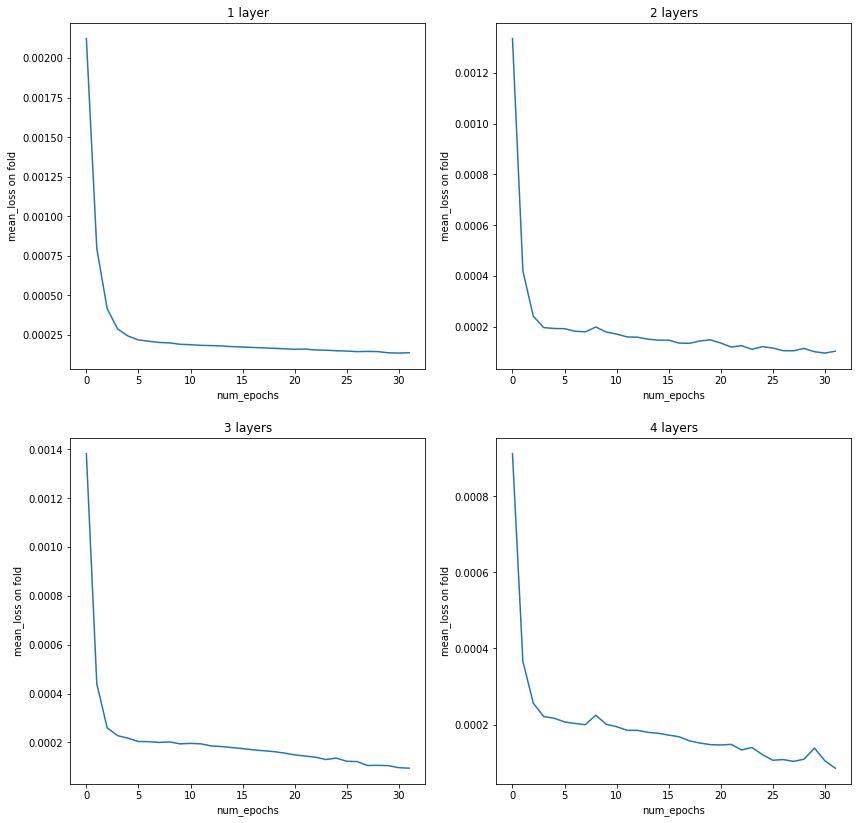

In [37]:
fig = plt.figure(figsize=(14, 14))

ax1 = fig.add_subplot(221, title='1 layer')
ax2 = fig.add_subplot(222, title='2 layers')
ax3 = fig.add_subplot(223, title='3 layers')
ax4 = fig.add_subplot(224, title='4 layers')

ax1.set_xlabel('num_epochs')
ax1.set_ylabel('mean_loss on fold')
ax1.plot(valid_losses_array[0])

ax2.set_xlabel('num_epochs')
ax2.set_ylabel('mean_loss on fold')
ax2.plot(valid_losses_array[1])

ax3.set_xlabel('num_epochs')
ax3.set_ylabel('mean_loss on fold')
ax3.plot(valid_losses_array[2])

ax4.set_xlabel('num_epochs')
ax4.set_ylabel('mean_loss on fold')
ax4.plot(valid_losses_array[3])

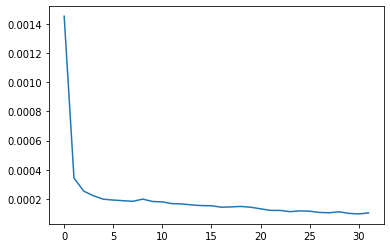

In [39]:
model = boston_regression_nn()
fc_layers = nn.Sequential(*list(model.children())[:-4]) # 2 hidden layers
model = nn.Sequential(
    fc_layers,
    nn.Linear(256, 1)
)

num_epochs = 32
valid_losses_array = np.zeros([hidden_layers, num_epochs])
res_losses = cross_valid_train(model, 2) # 2 hidden layers
plt.plot(np.arange(num_epochs), res_losses)

In [40]:
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_pred = model(X_test_torch)
y_pred_np = y_pred.detach().numpy()

In [41]:
MSE(y_test, y_pred_np)

0.0001150762908966157